<a href="https://colab.research.google.com/github/jieun1102/dprproject/blob/main/dpr_2011591.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN을 활용한 풍경 이미지 분류

---


[2024 DPR Proj] 수학과-4학년-2011591-이지은


###   **motivation**
* 본 프로젝트의 목표는 직접 촬영한 이미지 데이터인 숲과 바다 이미지를 분류하는 딥러닝 모델을 개발하는 것입니다. 수업 시간에 배웠던 CNN 분류 방법들에 대해 학습하면서 새로운 모델을 직접 만들면서 정확도를 높일 수 있는 방법에 대해 고찰해보고자 합니다.
더 나아가 환경 모니터링 및 보전에 사용될 수 있는 차원으로 발전시킬 수 있는 가능성을 열어 두고자 합니다.


###   **프로그램 데이터 패턴 종류**
* 숲, 바다 이미지 데이터를 이용하여 구분합니다.


### **데이터 수집 과정 및 augmentation 사용 기술**
* 이미지  데이터는 직접 촬영한 이미지로만 구성되어 있습니다. 데이터 augmetation 기술로 이미지 회전, 수평 및 수직 뒤집기, 확대 축소 등의 기법을 적용하여 데이터셋의 다양성을 증가시켰습니다.

* 전이학습이나 타인의 데이터는 따로 추가하지 않았고, 앞서 언급한 data augmetation 기술을 사용하여 데이터 부족 문제를 해결 하고자 했습니다.

* **데이터 크기 및 개수, 용량. 데이터 크기의 타당성** : 수집한 데이터는 숲 이미지 데이터 150개, 바다 데이터 140개로 총 290개 입니다. 데이터가 충분한 크기와 다양성을 갖추고, data augmetation을 사용하여 데이터의 다양성을 높였기 때문에 충분하다고 생각합니다.

# **프로그램 설명**

---



> 직접 수집한 이미지 데이터를 사용하여 숲과 바다를 구분하는 딥러닝 모델을 구축하고, 이를 평가하는 과정을 담고 있습니다.


### **1. 데이터 전처리 및 준비**
- load_data 함수를 사용하여 이미지 데이터를 로드하고 전처리합니다. 각 이미지는 크기를 조정하고, 레이블은 원-핫 인코딩되며, 이미지 데이터는 정규화됩니다.
- 또한 data augmetation을 위해 'ImageDataGenerator'를 사용하여 이미지를 회전, 이동, 반전, 확대/축소 등의 변환을 적용했습니다.

### **2. K-Fold 교차 검증 설정**
- 데이터를 5개의 fold로 나누어 교차 검증을 수행하기 위해 K-Fold를 설정했습니다.

### **3. 딥러닝 모델 정의**
- create_model 함수에서 CNN 아키텍처를 정의했습니다.
입력으로 (128,128,3) 크기의 이미지를 받아 Convolutional 층과 MaxPooling 층을 통해 특징을 추출한 후, Flatten과 Dense 층을 통해 분류를 수행했습니다.

### **4. K-Fold 교차 검증 실행 및 모델 학습**
- 각 fold에 대해 데이터를 학습 or 검증용으로 나눈 후, data argumetation을 적용하여 모델을 학습시킵니다. 학습 과정은 fit 메소드를 통해 수행되며, 각 fold 마다의 정확도와 손실을 기록했습니다.

### **5. 모델 평가 및 결과 출력**
- 각 fold에서 학습된 모델을 평가하고, 정확도와 손실을 출력했습니다.
- 테스트 이미지를 사용하여 모델의 예측을 수행하고, 결과를 출력했습니다.

### **6. 결과 분석 및 그래프 표시**
- 각 fold의 학습 및 검증 정확도 및 손실을 그래프로 시각화하여 분석했습니다.
- 모든 fold의 평균 정확도와 손실을 계산하고 출력했습니다.


#필요한 package import

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import History
from PIL import Image

# GitHub에서 직접 생성한 이미지 데이터 가져오기

In [21]:
# GitHub에서 데이터 다운로드
!git clone https://github.com/jieun1102/dprproject.git

#데이터 디렉토리 경로 설정
data_dir = './dprproject/data/'

#테스트 데이터 디렉토리 경로 설정
test_dir = './dprproject/data/test/'

fatal: destination path 'dprproject' already exists and is not an empty directory.


#데이터 전처리 함수 정의(데이터 디렉토리로부터 이미지 데이터와 레이블을 로드)

In [24]:
# 데이터 전처리 함수 정의
def load_data(data_dir):
    categories = ['sea', 'forest'] #카테고리 정의
    data = [] #이미지 데이터를 저장할 리스트
    labels = [] #레이블을 저장할 리스트
    for category in categories: #각 카테고리 반복
        path = os.path.join(data_dir, category) #카테고리의 경로 설정
        class_num = categories.index(category) #카테고리 인덱스 레이블 설정
        for img in os.listdir(path): #각 카테고리 내의 이미지 파일 반복
            try:
                img_array = cv2.imread(os.path.join(path, img)) #이미지 파일을 읽고
                if img_array is not None: # 이미지가 비어 있지 않은 경우에만 처리
                    resized_img = cv2.resize(img_array, (128, 128)) #일관된 크기로 입력을 주기 위해(+효율성 증대) 이미지 크기를 128x128로 조정
                    data.append(resized_img) #크기가 조정된 이미지 데이터를 리스트에 추가
                    labels.append(class_num) #이미지에 해당하는 레이블을 리스트에 추가
                else:
                   print(f"이미지 {img}가 비어 있습니다.") # 이미지가 비어 있는 경우에 메시지 출력
            except Exception as e: #이미지 파일을 읽을 수 없는 경우 예외 처리
                print(e) #에러 메시지 출력
    return np.array(data), np.array(labels) #효율성과 일관성을 유지하기 위해 이미지 데이터와 레이블을 numpy 배열로 반환

# 데이터 불러오기

In [25]:
# data_dir 은 이미지 데이터가 저장된 디렉토리의 경로이고, 해당 디렉토리에는 sea와 forest 서브 디렉토리가 있음
# load_data(data_dir) 함수 호출을 통해 이미지 데이터와 레이블이 변수 images와 labels에 각각 저장되어 이후 전처리 및 학습에 활용됨

images, labels = load_data(data_dir)

이미지 readme.md가 비어 있습니다.
이미지 readme.md가 비어 있습니다.


In [26]:
# 레이블을 원-핫 인코딩(다중 클래스 분류에서 모델의 성능을 향상시키는데 도움이 되므로)으로 변환
lb = LabelBinarizer() #클래스 레이블을 고유한 이진 벡터로 매핑하는 데 사용함
labels = lb.fit_transform(labels) #레이블 데이터를 입력으로 받아, 각 클래스 레이블을 이진 벡터로 매핑하고 변환된 이진 벡터로 구성된 배열 반환
labels = to_categorical(labels) #이진 벡터로 변환된 레이블을 원 핫 인코딩 형식으로 반환, 다중 클래스 분류 모델에 적합한 형태로 변환하는 과정

In [27]:
# 이미지 데이터 정규화
# 이미지 데이터를 0과 1 사이의 값으로 정규화하여 모델의 학습을 안정화시킴(0~255)
images = images / 255.0

#data augmetation

In [28]:
# data augmetation을 위한 ImageDataGenerator 생성
# 과적합을 방지하고, 데이터 부족 문제를 해결 및 일반화된 모델을 생성 위함, 데이터의 다양성을 높여줄 수 있음
# 여러 번 시도해서 최적의 값 찾기
datagen = ImageDataGenerator(
    rotation_range=20,  # 랜덤하게 이미지를 최대 20도 회전
    width_shift_range=0.1,  # 랜덤하게 이미지를 가로로 최대 10% 이동
    height_shift_range=0.1,  # 랜덤하게 이미지를 세로로 최대 10% 이동
    horizontal_flip=True,  # 랜덤하게 이미지를 수평으로 뒤집기
    zoom_range=0.1  # 랜덤하게 이미지를 최대 10% 확대/축소
)

#K-Fold 교차 검증 설정

In [ ]:
# K-Fold 교차 검증 설정
# 모델의 일반화 성능을 평가하기 위함
# 데이터를 5개의 폴드로 나눔(총 5번의 반복 검증), 모든 폴드에 다른 데이터가 포함되도록 (true), 재현 가능한 결과를 얻기 위해 설정, 동일한 코드 실행시 동일한 분할 생성
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#각 폴드에서의 모델 성능을 확인, 전반적인 성능 평가 가능
acc_per_fold = [] #k-Fold에서 얻은 정확도를 저장하는 리스트
loss_per_fold = [] #k-Fold에서 얻은 손실을 저장하는 리스트

#CNN 모델 함수 정의

In [ ]:
# 각 레이어는 sequential 모델 내에 순차적으로 추가되며, 마지막에는 compile 메서드를 사용하여 모델을 컴파일함
# Con2D 레이어를 중첩함으로써 깊은 특징 추출
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), #2차원 컨볼루션 레이어, 출력 필터 : 32개(간단한 특징 추출), 컨볼루션 커널 크기 :(3,3)
        MaxPooling2D(pool_size=(2, 2)), #최대 풀링 레이어,
        Conv2D(64, (3, 3), activation='relu'), #2차원 컨볼루션 레이어, 출력 필터 : 64개(더 깊은 내용 추출), 컨볼루션 커널 크기 :(3,3)
        MaxPooling2D(pool_size=(2, 2)), #Conv2D 레이어의 출력을 입력으로 받아 작은 영역으로 이미지를 나누고, 각 영역에서 최대값을 선택하여 출력(공간적인 차원 절반으로 줄어듦)
        Flatten(), #n차원의 데이터를 1차원으로
        Dense(128, activation='relu'),#위와 동일한 과정 반복하여 공간적인 차원을 줄임
        Dropout(0.5), #과적합 방지위해 dropout 레이어 적용
        Dense(2, activation='softmax') #출력 레이어 정의, 소프트맥스 사용-다중 클래스 분류문제 해결
    ])
    #Adam - 경사하강법(모델의 가중치 업데이트 하는데 사용), 손실 함수로 categorical crossentropy 사용, 모델 성능 평가 사용 지표로 정확도 사용
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#K-Fold 교차 검증 실행

Epoch 1/10
7/7 [==============================] - 10s 1s/step - loss: 1.0136 - accuracy: 0.6897 - val_loss: 0.1320 - val_accuracy: 0.9483
Epoch 2/10
7/7 [==============================] - 12s 2s/step - loss: 0.0952 - accuracy: 0.9612 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 0.1242 - accuracy: 0.9698 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 8s 1s/step - loss: 0.1537 - accuracy: 0.9224 - val_loss: 0.0936 - val_accuracy: 0.9655
Epoch 5/10
7/7 [==============================] - 6s 869ms/step - loss: 0.1291 - accuracy: 0.9440 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 7s 905ms/step - loss: 0.1447 - accuracy: 0.9483 - val_loss: 0.0343 - val_accuracy: 0.9828
Epoch 7/10
7/7 [==============================] - 8s 1s/step - loss: 0.0880 - accuracy: 0.9612 - val_loss: 0.0544 - val_accuracy: 0.9828
Epoch 8/10
7/7 [=================

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


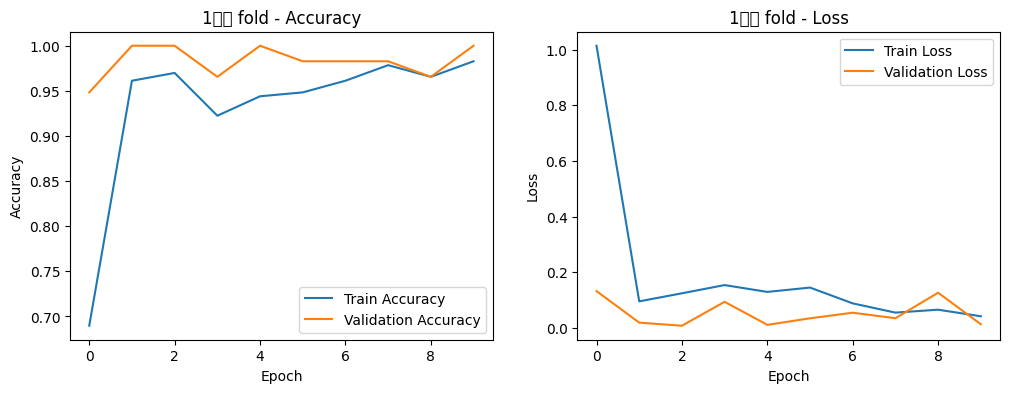

Epoch 1/10
7/7 [==============================] - 8s 889ms/step - loss: 0.6924 - accuracy: 0.7672 - val_loss: 0.1331 - val_accuracy: 0.9310
Epoch 2/10
7/7 [==============================] - 8s 969ms/step - loss: 0.1208 - accuracy: 0.9569 - val_loss: 0.1691 - val_accuracy: 0.9138
Epoch 3/10
7/7 [==============================] - 6s 847ms/step - loss: 0.1401 - accuracy: 0.9526 - val_loss: 0.2459 - val_accuracy: 0.8966
Epoch 4/10
7/7 [==============================] - 8s 1s/step - loss: 0.1531 - accuracy: 0.9353 - val_loss: 0.4056 - val_accuracy: 0.8793
Epoch 5/10
7/7 [==============================] - 8s 1s/step - loss: 0.0989 - accuracy: 0.9741 - val_loss: 0.0979 - val_accuracy: 0.9655
Epoch 6/10
7/7 [==============================] - 6s 860ms/step - loss: 0.0470 - accuracy: 0.9914 - val_loss: 0.2226 - val_accuracy: 0.9138
Epoch 7/10
7/7 [==============================] - 12s 2s/step - loss: 0.0627 - accuracy: 0.9828 - val_loss: 0.0866 - val_accuracy: 0.9483
Epoch 8/10
7/7 [============

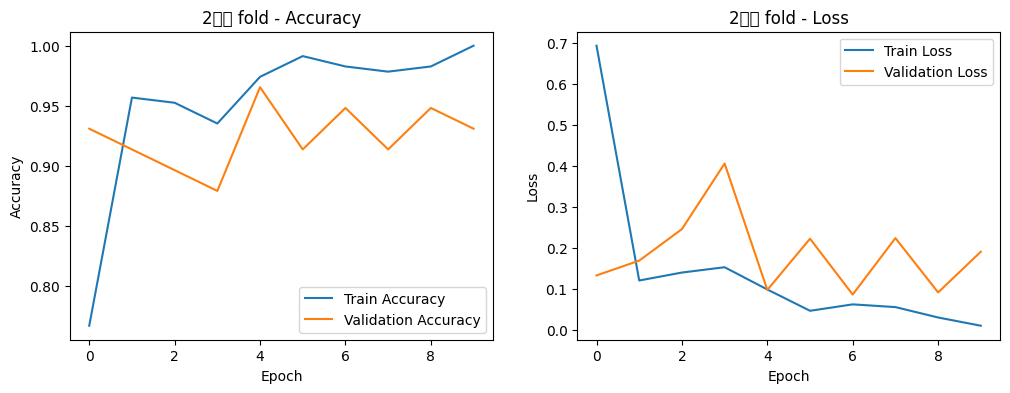

Epoch 1/10
7/7 [==============================] - 8s 850ms/step - loss: 1.0043 - accuracy: 0.6379 - val_loss: 0.2409 - val_accuracy: 0.9655
Epoch 2/10
7/7 [==============================] - 8s 961ms/step - loss: 0.1897 - accuracy: 0.9397 - val_loss: 0.0432 - val_accuracy: 1.0000
Epoch 3/10
7/7 [==============================] - 7s 1s/step - loss: 0.1063 - accuracy: 0.9612 - val_loss: 0.0222 - val_accuracy: 0.9828
Epoch 4/10
7/7 [==============================] - 6s 979ms/step - loss: 0.1080 - accuracy: 0.9612 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 7s 797ms/step - loss: 0.0858 - accuracy: 0.9569 - val_loss: 0.0790 - val_accuracy: 0.9655
Epoch 6/10
7/7 [==============================] - 8s 1s/step - loss: 0.0839 - accuracy: 0.9741 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 7s 962ms/step - loss: 0.0696 - accuracy: 0.9784 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 8/10
7/7 [==========

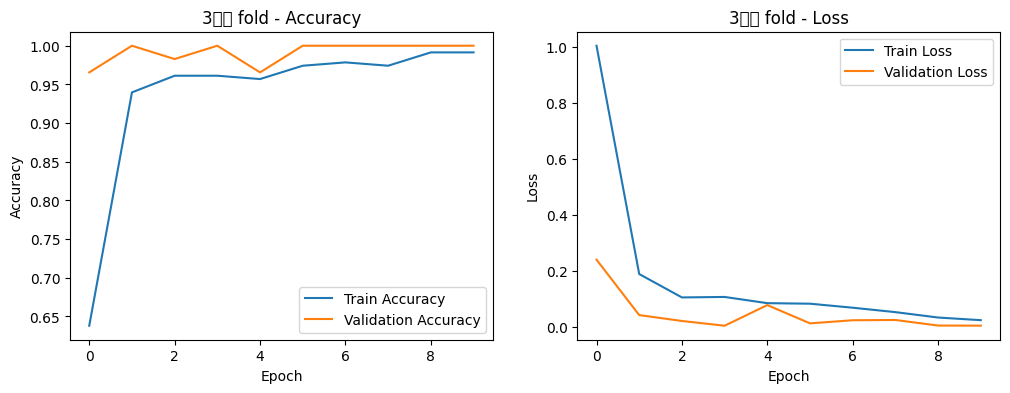

Epoch 1/10
7/7 [==============================] - 8s 912ms/step - loss: 3.2948 - accuracy: 0.5819 - val_loss: 1.7780 - val_accuracy: 0.5862
Epoch 2/10
7/7 [==============================] - 6s 862ms/step - loss: 0.4987 - accuracy: 0.8534 - val_loss: 0.0410 - val_accuracy: 0.9828
Epoch 3/10
7/7 [==============================] - 8s 1s/step - loss: 0.0927 - accuracy: 0.9784 - val_loss: 0.0666 - val_accuracy: 0.9828
Epoch 4/10
7/7 [==============================] - 6s 863ms/step - loss: 0.0726 - accuracy: 0.9698 - val_loss: 0.1826 - val_accuracy: 0.9828
Epoch 5/10
7/7 [==============================] - 8s 1s/step - loss: 0.0566 - accuracy: 0.9741 - val_loss: 0.1571 - val_accuracy: 0.9828
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.0789 - accuracy: 0.9612 - val_loss: 0.1289 - val_accuracy: 0.9828
Epoch 7/10
7/7 [==============================] - 7s 845ms/step - loss: 0.0473 - accuracy: 0.9741 - val_loss: 0.1640 - val_accuracy: 0.9828
Epoch 8/10
7/7 [=============

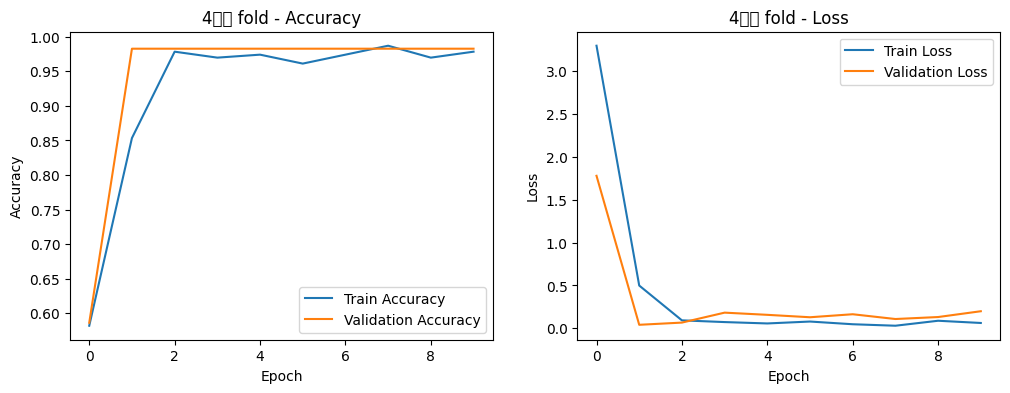

Epoch 1/10
7/7 [==============================] - 9s 1s/step - loss: 1.8431 - accuracy: 0.5647 - val_loss: 0.5079 - val_accuracy: 0.6379
Epoch 2/10
7/7 [==============================] - 7s 887ms/step - loss: 0.2848 - accuracy: 0.8707 - val_loss: 0.1214 - val_accuracy: 0.9483
Epoch 3/10
7/7 [==============================] - 7s 877ms/step - loss: 0.1154 - accuracy: 0.9698 - val_loss: 0.1681 - val_accuracy: 0.9655
Epoch 4/10
7/7 [==============================] - 8s 973ms/step - loss: 0.0980 - accuracy: 0.9698 - val_loss: 0.0661 - val_accuracy: 0.9828
Epoch 5/10
7/7 [==============================] - 8s 1s/step - loss: 0.0784 - accuracy: 0.9698 - val_loss: 0.0627 - val_accuracy: 0.9655
Epoch 6/10
7/7 [==============================] - 6s 861ms/step - loss: 0.0402 - accuracy: 0.9914 - val_loss: 0.0481 - val_accuracy: 0.9655
Epoch 7/10
7/7 [==============================] - 8s 1s/step - loss: 0.0251 - accuracy: 0.9957 - val_loss: 0.1239 - val_accuracy: 0.9655
Epoch 8/10
7/7 [=============

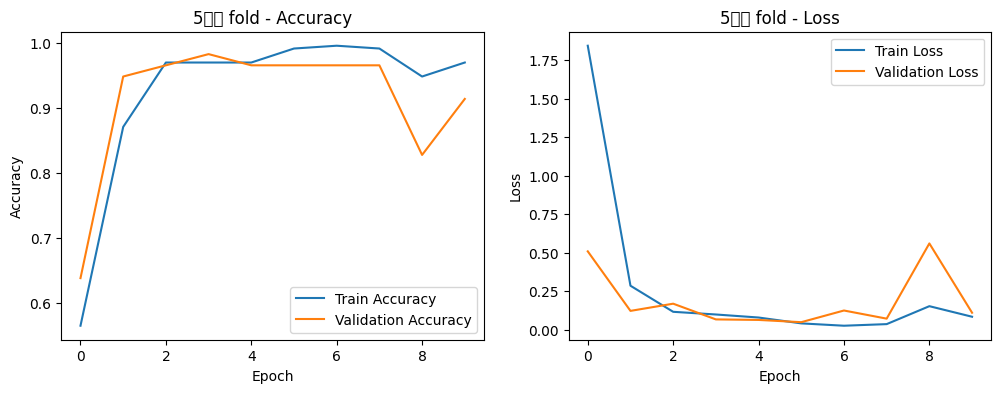

In [ ]:
fold_no = 1
for train_index, val_index in kf.split(images): #train_index : 학습 세트의 인덱스. val_index : 검증 세트의 인덱스 , kf.split(images) : 이미지 데이터를 K개의 폴드로 나누는 인덱스 생성
    x_train, x_val = images[train_index], images[val_index] # x_train : 학습 데이터, x_val : 검증 데이터
    y_train, y_val = labels[train_index], labels[val_index] # y_train : 학습 레이블. y_val : 검증 데이터

    # 모델 생성
    model = create_model()

    # 데이터 증강 적용하여 모델 학습
    history = History() #학습한 내용을 저장할 수 있는 객체 생성
    datagen.fit(x_train) #데이터 증강을 적용할 이미지 데이터에 대해 ImageDataGenerator 적용, 필요한 내부 파라미터를 계산하기 위함
    model.fit(datagen.flow(x_train, y_train, batch_size=32), #model.fit()을 사용하여 모델 학습, datagen.flow(x_train, y_train, batch_size=32)는 데이터 증강이 적용된 이미지와 레이블 배치를 생성하는 제너레이터 반환
              steps_per_epoch=len(x_train) / 32, epochs=10, validation_data=(x_val, y_val), #학습 데이터의 총 샘플 수를 배치 크기로 나눈 값, 총 학습 반복회수(10), 검증 데이터 지정
              callbacks=[history]) #콜백 함수 : 학습 기록을 저장하는 History 객체를 전달


    # 학습된 모델 평가(각 fold에 대해 모델의 성능을 평가하고, 정확도와 손실값을 저장하는 과정)
    # 모델 평가
    scores = model.evaluate(x_val, y_val, verbose=0) # 검증 데이터 x_val과 y_val을 사용하여 학습된 모델 평가, verbose=0 : 평가 중 출력되는 메시지 생략, scores : 평가 결과(정확도, 손실값 포함)

    # 평가 결과 출력
    # scores[0] : 손실값(loss). scores[1] : 정확도(accuracy)
    # f-string을 활용하여 각 fold의 평가 결과를 명확하게 보임
    print(f' {fold_no}번째 fold 결과 : loss =  {scores[0]}; accuracy = {scores[1]*100}%')

    # fold별 정확도와 손실값 저장
    acc_per_fold.append(scores[1] * 100) # 정확도를 퍼센트로 변환하여 리스트에 추가
    loss_per_fold.append(scores[0]) #손실값을 리스트에 추가


    # 학습 및 검증 정확도 그래프 출력 (과적합 확인 및 모델 성능 비교 위함)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{fold_no}번째 fold - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 학습 및 검증 손실 그래프 출력
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{fold_no}'s fold - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    fold_no += 1

#모든 Fold의 평균 점수 계산 및 출력

In [ ]:
# 다양한 데이터 분할에서 일관되는지 확인
print('------------------------------------------------------------------------')
print('각 fold별 score')
for i in range(0, len(acc_per_fold)):
    print(f'> {i+1}번째 fold - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('모든 fold의 평균 score:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
각 fold별 score
> 1번째 fold - Loss: 0.013073396869003773 - Accuracy: 100.0%
> 2번째 fold - Loss: 0.19086693227291107 - Accuracy: 93.1034505367279%
> 3번째 fold - Loss: 0.005564411636441946 - Accuracy: 100.0%
> 4번째 fold - Loss: 0.19906598329544067 - Accuracy: 98.2758641242981%
> 5번째 fold - Loss: 0.10948019474744797 - Accuracy: 91.37930870056152%
------------------------------------------------------------------------
모든 fold의 평균 score:
> Accuracy: 96.5517246723175 (+- 3.6165824702317004)
> Loss: 0.10361018376424909
------------------------------------------------------------------------


#테스트 이미지 불러오기 및 전처리

In [ ]:
test_images = [] # 전처리된 테스트 이미지 저장할 리스트
test_image_paths = []  # 테스트 이미지 파일 경로 저장할 리스트
for filename in os.listdir(test_dir): # test_dir 내의 모든 파일 이름 반복
    if filename.endswith(('.jpg', '.jpeg', '.png')): # 파일 확장자 명이 해당 경우에만 처리
        img = Image.open(os.path.join(test_dir, filename)) #img 변수에 저장
        img = img.resize((128, 128))  # 모델의 입력 크기와 일치하도록 크기 조정
        img_array = np.array(img) / 255.0  # 이미지를 numpy 배열로 변환, 각 픽셀 값을 0과 1 사이의 값으로 정규화
        test_images.append(img_array) # 정규화된 이미지를 test_images 리스트에 추가
        test_image_paths.append(os.path.join(test_dir, filename))  # 이미지 파일 경로를 test_images_paths 리스트에 추가


#예측 수행 및 결과 출력

1/1 [==============================] - 0s 158ms/step
이미지 1: ./dprproject/data/test/testimage2.jpg - 예측: 숲, 정확도: 92.69%
1/1 [==============================] - 0s 28ms/step
이미지 2: ./dprproject/data/test/testimage1.jpg - 예측: 숲, 정확도: 79.12%
1/1 [==============================] - 0s 28ms/step
이미지 3: ./dprproject/data/test/testimage3.jpg - 예측: 숲, 정확도: 99.47%


<ipython-input-13-8e5e2d7f9e9a>:17: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  plt.tight_layout()
<ipython-input-13-8e5e2d7f9e9a>:17: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  plt.tight_layout()
<ipython-input-13-8e5e2d7f9e9a>:17: UserWarning: Glyph 49714 (\N{HANGUL SYLLABLE SUP}) missing from current font.
  plt.tight_layout()
<ipython-input-13-8e5e2d7f9e9a>:17: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
<ipython-input-13-8e5e2d7f9e9a>:17: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  plt.tight_layout()
<ipython-input-13-8e5e2d7f9e9a>:17: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **k

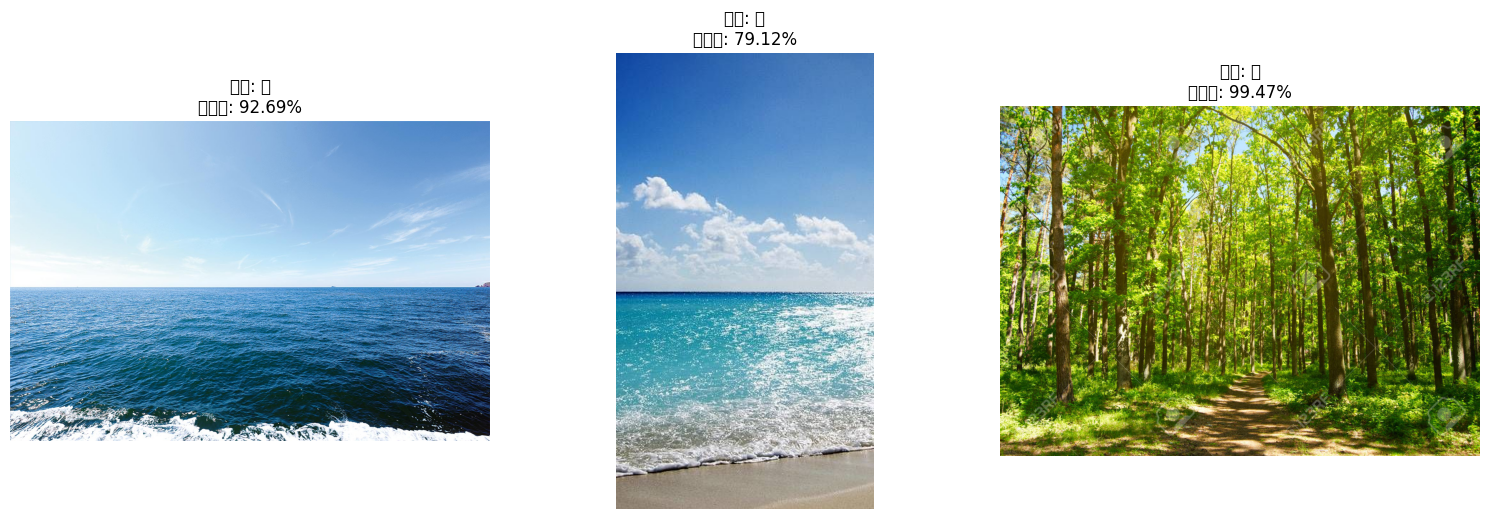

In [ ]:
plt.figure(figsize=(15, 10))
for i, (img_array, img_path) in enumerate(zip(test_images, test_image_paths), start = 1): # enumerate 함수를 사용해 index i, img_array, img_path를 얻음
    #zip 함수를 사용하여 각 테스트 이미지의 파일명과 해당 이미지의 예측 결과 및 정확도 출력

    img_array = np.expand_dims(img_array, axis=0)  # batch 차원 추가
    prediction = model.predict(img_array) # 모델을 사용하여 이미지 예측, prediction 변수에 모델의 예측 결과 저장됨
    predicted_label = "sea" if prediction[0][0] > prediction[0][1] else "forest"
    accuracy = max(prediction[0]) * 100

    plt.subplot(2, 3, i)
    plt.imshow(Image.open(img_path))
    plt.title(f"predict: {predicted_label}\naccuracy: {accuracy:.2f}%")
    plt.axis('off')

    print(f"image {i}: {img_path} - predict: {predicted_label}, accuracy: {accuracy:.2f}%")

plt.tight_layout()
plt.show()




*   결과에 대한 충분한 분석과 설명

*   프로젝트를 위해 활용한 자료나 동영상 링크



*  본 프로젝트를 통해 느낀점
 - 딥러닝 모델을 구축하고 평가하는 과정을 직접 느낄 수 있었습니다. 데이터 전처리부터 모델 정의, 학습, 평가까지의 가정을 직접 수행해보면서 딥러닝의 기본적인 원리와 방법을 이해할 수 있었습니다.
  이 프로젝트에서는 데이터의 양과 질이 모델의 성능에 큰 영향을 미친다는 것을 깨달았습니다. 데이터의 양이 적을 경우 모델의 일반화 성능이 저하될 수 있으며, 데이터의 다양성이 부족할 경우 모델이 특정 패턴에 과적합될 수 있음을 알게 되었습니다.
  모델의 성능을 향상시키기 위해서는 적절한 학습률, batch 크기, 레이어 수 등을 조정하여 모델의 성능을 최적화할 수 있다는 것을 경험할 수 있었습니다,
  정확도와 손실으로는 모델의 성능을 완전히 이해하기 어렵기 때문에 그래프를 통해 시각화하고 평가 지표를 종합적으로 고려하는 것이 필요하다는 것도 깨달았습니다.
  이 프로젝트를 통해 딥러닝의 기초를 학습할 수 있어 좋았지만 아직 배워야 할 것이 많음을 느꼈습니다.
*  프로젝트 수행 과정에 대한 간략한 일정 고찰